In [0]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 23 13:20:15 2019

@author: chin-weihuang
"""


from __future__ import print_function
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import samplers


############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4

#######--- INSERT YOUR CODE BELOW ---#######
      
class Critic(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=10,output_size=1):
        super(Critic, self).__init__()
        
        self.minibatch_size = 512
        self.lr = 1e-3
        self.epoch_count = 2
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
        
    def forward(self, x):
          
        return self.layers(x)
      
def WGAN_GPloss(x_val, minibatch_size, epoch_count, learning_rate, losses,\
                input_size, hidden_size, output_size, penalty_coef = 10,\
                real_sampler=samplers.distribution1,\
                fake_sampler=samplers.distribution1,\
               ):
  #critic.zero_grad()
  critic = Critic(input_size, hidden_size, output_size).cuda()
  optimizer = optim.SGD(critic.parameters(),lr = learning_rate)

  #get data for both distributions from samplers
  real_dist = iter(real_sampler(x_val,512))
  real_samples = next(real_dist)
  real_tensor_samples = torch.tensor(real_samples, requires_grad = True).float().cuda()

  fake_dist = iter(fake_sampler(0,512)) 
  fake_samples = next(fake_dist)
  fake_tensor_samples = torch.tensor(fake_samples, requires_grad = True).float().cuda()

################################gradient penalty################################
  
################################################################################
  
  for i in range(epoch_count):
    critic.zero_grad()
    optimizer.zero_grad()
    
    real_critic_output = critic(real_tensor_samples)
    fake_critic_output = critic(fake_tensor_samples)
    
    #make mix
    alpha = torch.rand([1]).cuda() #mixing coefficient, might need to be made 512 dim
    z = alpha*real_tensor_samples + (1-alpha)*fake_tensor_samples
    critic_z = critic(z)

    #compute gradient of critic(z) w.r.t. z
    grads = torch.autograd.grad(outputs = critic_z, \
                                inputs = z, \
                                grad_outputs = torch.ones([512,2]).cuda(), \
                                #might have to change dimension for grad_outputs
                                only_inputs = True, \
                                create_graph = True,
                                retain_graph = True
                               )[0]
    
    #compute the full penalty (coef*mean of norm of grad)
    grad_penalty = ((torch.norm(grads, p=2, dim=1)-1)**2)
  
    real_critic_output_expected = real_critic_output.mean()
    fake_critic_output_expected = fake_critic_output.mean()
    grad_penalty_mean = grad_penalty.mean()
    
    total_output = -real_critic_output_expected + fake_critic_output_expected + \
                    penalty_coef*(grad_penalty_mean)
    
    total_output.backward()
    optimizer.step()
    
  return -total_output
#   return total_output
    

In [0]:
distances = []
for phi in np.linspace(-1,1,21):
  wgan_gp = WGAN_GPloss(x_val=phi, minibatch_size=512, epoch_count=1000, learning_rate = 1e-3, losses = losses,\
                        input_size=2, hidden_size=10, output_size=1, \
                        real_sampler=samplers.distribution1,\
                        fake_sampler=samplers.distribution1,\
                       )
  distances.append(wgan_gp)

In [0]:
losses = []
wgan_gp = WGAN_GPloss(x_val=0, minibatch_size=512, epoch_count=100, learning_rate = 1e-3, losses = losses,\
                      input_size=2, hidden_size=10, output_size=1, \
                      real_sampler=samplers.distribution1,\
                      fake_sampler=samplers.distribution1,\
                     )

# losses_investigation
losses = []
# for i in np.linspace(-1,1,21):
critic = Critic(input_size=2, hidden_size=10, output_size=1).cuda()
optimizer = optim.SGD(critic.parameters(),lr = 1e-3)

#get data for both distributions from samplers
real_dist = iter(samplers.distribution1(1,512))
real_samples = next(real_dist)
real_tensor_samples = torch.tensor(real_samples, requires_grad = True).float().cuda()

fake_dist = iter(samplers.distribution1(0,512)) 
fake_samples = next(fake_dist)
fake_tensor_samples = torch.tensor(fake_samples, requires_grad = True).float().cuda()
penalty_coef = 10 #or higher if needed


for j in range(10000):
  critic.zero_grad()
  optimizer.zero_grad()
  real_critic_output = critic(real_tensor_samples)
  fake_critic_output = critic(fake_tensor_samples)

  alpha = torch.rand([1]).cuda() #mixing coefficient
  z = alpha*real_tensor_samples + (1-alpha)*fake_tensor_samples
  critic_z = critic(z)

  grads = torch.autograd.grad(outputs = critic_z, \
                              inputs = z, \
                              grad_outputs = torch.ones([512,2]).cuda(), \
                              #might have to change dimension for grad_outputs
                              only_inputs = True, \
                              create_graph = True,
                              retain_graph = True
                             )[0]
  #compute the full penalty (coef*mean of norm of grad)
  grad_penalty = ((torch.norm(grads, p=2, dim=1)-1)**2)

  real_critic_output_expected = real_critic_output.mean()
  fake_critic_output_expected = fake_critic_output.mean()
  grad_penalty_mean = grad_penalty.mean()

  total_output = -real_critic_output_expected + fake_critic_output_expected + \
                  penalty_coef*(grad_penalty_mean)

  total_output.backward()
  optimizer.step()

  losses.append(-total_output)


[tensor(0.5051, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5068, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5069, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5068, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5049, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5068, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5050, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5050, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5067, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5061, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5068, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5061, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5065, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5068, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5068, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5068, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5069, device='cuda:0', grad_fn=<NegBackward>),
 tensor(0.5068, device='cuda:0'

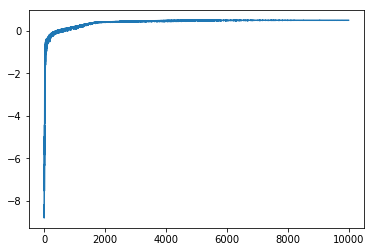

In [35]:
plt.plot(losses)
losses[-100:]